In [28]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [29]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip -q cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-06-11 00:47:43--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   182MB/s    in 0.4s    

2024-06-11 00:47:44 (182 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [30]:
# 3
train_image_generator = ImageDataGenerator(rescale = 1/255.0)
validation_image_generator = ImageDataGenerator(rescale=1/255.0)
test_image_generator = ImageDataGenerator(rescale=1/255.0)

train_data_gen = train_image_generator.flow_from_directory(
    directory = train_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    class_mode='binary'
)
val_data_gen = validation_image_generator.flow_from_directory(
    directory = validation_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    class_mode='binary'
)
test_data_gen = test_image_generator.flow_from_directory(
    directory = PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    shuffle = False,
    classes = ['test']
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


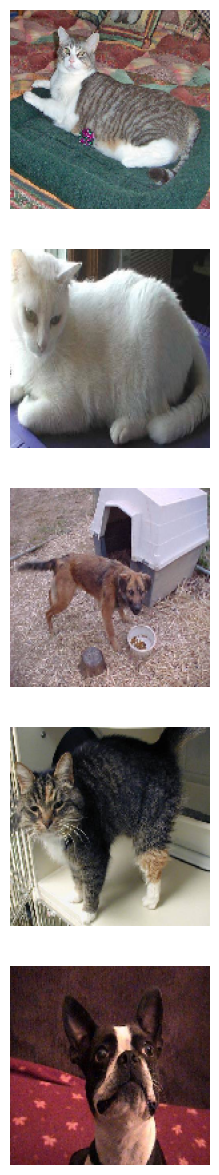

In [31]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [32]:
# 5
train_image_generator = train_image_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True
)


Found 2000 images belonging to 2 classes.


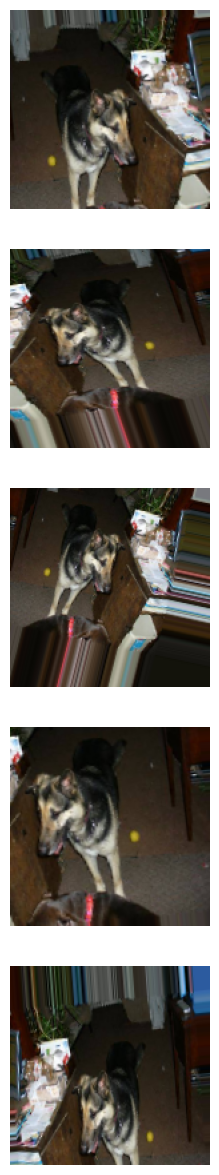

In [33]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary' )

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [45]:
# 7
#from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

input_layer = Input(train_data_gen.image_shape)

x = x = tf.keras.applications.VGG16(include_top=False)(input_layer)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = Dense(512, 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(256, 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(8, 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dense(1, 'sigmoid')(x)

model = Model(input_layer, x)

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_40 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_30 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                           

In [46]:
# 8
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath="best_accuracy.keras",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

eraly_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', patience = 3, restore_best_weights=True)

history = model.fit(
    train_data_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = val_data_gen,
    callbacks = [save_best, eraly_stopping]
)

Epoch 1/15
16/16 [==============================] - ETA: 0s - loss: 0.7113 - accuracy: 0.5650
Epoch 1: val_loss improved from inf to 326.56744, saving model to best_accuracy.keras
16/16 [==============================] - 101s 4s/step - loss: 0.7113 - accuracy: 0.5650 - val_loss: 326.5674 - val_accuracy: 0.5000
Epoch 2/15
16/16 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.5895
Epoch 2: val_loss did not improve from 326.56744
16/16 [==============================] - 22s 1s/step - loss: 0.6704 - accuracy: 0.5895 - val_loss: 375.3834 - val_accuracy: 0.5000
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 0.6579 - accuracy: 0.5985
Epoch 3: val_loss improved from 326.56744 to 91.65784, saving model to best_accuracy.keras
16/16 [==============================] - 23s 1s/step - loss: 0.6579 - accuracy: 0.5985 - val_loss: 91.6578 - val_accuracy: 0.5000
Epoch 4/15
16/16 [==============================] - ETA: 0s - loss: 0.6510 - accuracy: 0.6145
Epoch

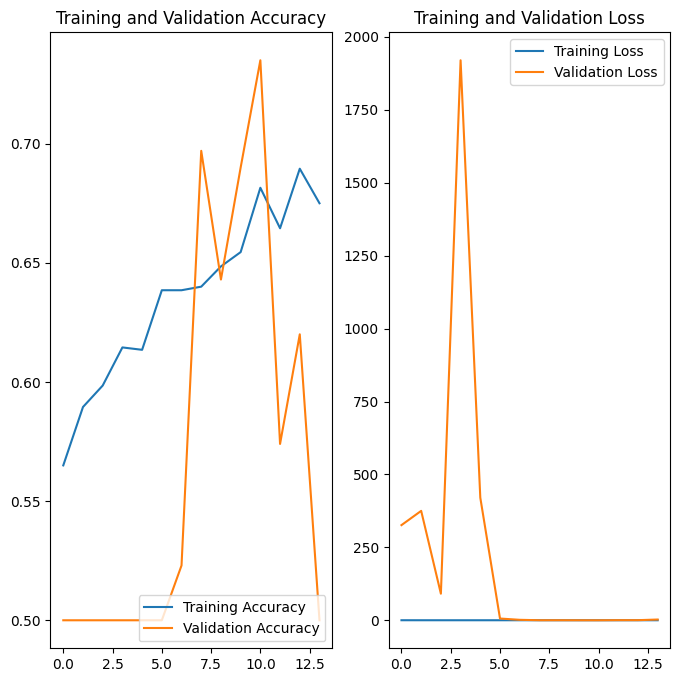

In [51]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(len(history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
#model.load_weights("/content/best_accuracy.keras")
probabilities = model.predict(test_data_gen).flatten()
probabilities

1/1 [==============================] - 6s 6s/step


array([0.66908354, 0.18352988, 0.38570964, 0.38523006, 0.3987608 ,
       0.63402677, 0.49093434, 0.17830019, 0.9458362 , 0.98819387,
       0.51607156, 0.7994942 , 0.54899967, 0.35436654, 0.49934414,
       0.7093357 , 0.55709344, 0.6487463 , 0.86300546, 0.78012675,
       0.2077017 , 0.79082483, 0.43705118, 0.91835994, 0.6523011 ,
       0.74063164, 0.9903735 , 0.31383324, 0.21762335, 0.3657303 ,
       0.39990604, 0.17230567, 0.9570984 , 0.9995327 , 0.47289577,
       0.66452265, 0.9960224 , 0.9397904 , 0.882729  , 0.29199445,
       0.22668219, 0.4080123 , 0.89892054, 0.601651  , 0.23565589,
       0.2682462 , 0.2739547 , 0.41199833, 0.31002498, 0.19845557],
      dtype=float32)

In [50]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 82.0% of the images of cats and dogs.
You passed the challenge!


<ipython-input-31-e7cffa4c9536>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
<ipython-input-31-e7cffa4c9536>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % (probability*100) + "% dog")


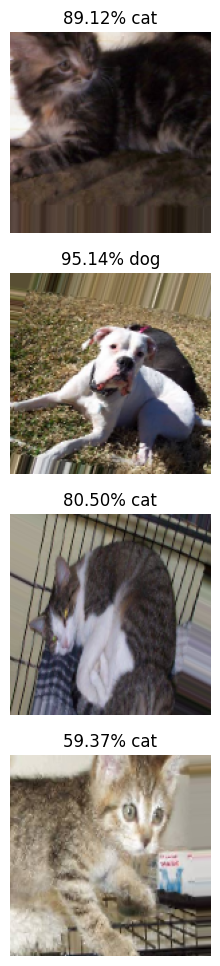

In [63]:
sample_training_images, _ = next(train_data_gen)
probabilities = model.predict(sample_training_images, verbose = 0)
plotImages(sample_training_images[:4], probabilities)
